<a href="https://colab.research.google.com/github/Axemoth/AI-ML-projects/blob/main/yolov8_with_webcam_and_user_upload_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

⬇️  Preparing to use YOLOv8 model...
✅ YOLOv8 model setup does not require manual file downloads.
📸 Choose an option: Take a photo from webcam (type 'webcam') or upload an image (type 'upload').
upload
⬆️  Upload an image file.


Saving img3.png to img3.png
File 'img3.png' uploaded.
🧠 Loading PyTorch YOLOv8 model...
Checking for ultralytics library...
✅ ultralytics library found.
✅ PyTorch YOLOv8 model loaded.
✅ Class names loaded from model.
🏃 Running PyTorch model inference...

0: 640x576 1 person, 213.3ms
Speed: 10.1ms preprocess, 213.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)
🔍 Processing detections...

🎉 Detection Complete! Displaying result:
🚫 No objects detected above confidence threshold.


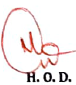


📊 Object Summary:
❌ No objects detected above threshold.


In [6]:
# @title Cell 1: Download AI Model Files (PyTorch Compatible)
# Run this cell first. It downloads the pre-trained YOLOv8 model weights
# compatible with PyTorch, as well as the necessary configuration and class names files.

print("⬇️  Preparing to use YOLOv8 model...")

# YOLOv8 does not require separate download of weights, cfg, or names files
# when loading directly via torch.hub or the ultralytics library.
# The necessary files are handled internally by the library.

print("✅ YOLOv8 model setup does not require manual file downloads.")
# The following line is commented out as it's not needed for the webcam/upload functionality
# !yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

# ==============================================================================

# @title Cell 2: Capture a Photo from Your Webcam or Upload an Image and Run Object Detection (PyTorch)
# This cell combines taking a photo or uploading an image and running object detection.
# It uses your browser's capabilities to access your webcam, takes a picture,
# loads the PyTorch AI model, finds the objects in the photo, and draws boxes and labels on them.

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import torch
import numpy as np
from google.colab.patches import cv2_imshow # Special function for Colab
from google.colab import files # Import files for uploading

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture button to be clicked
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 20, video.videoWidth, video.videoHeight - 40); # Adjusted y and height
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename


print("📸 Choose an option: Take a photo from webcam (type 'webcam') or upload an image (type 'upload').")
option = input().lower()

image_file = None

if option == 'webcam':
    print("📸 Running this cell to take a photo and run object detection. You may need to grant camera permissions.")
    image_file = take_photo()
    print(f"Photo saved as {image_file}")
elif option == 'upload':
    print("⬆️  Upload an image file.")
    uploaded = files.upload()
    if uploaded:
        # Assuming only one file is uploaded
        image_file = list(uploaded.keys())[0]
        print(f"File '{image_file}' uploaded.")
    else:
        print("❌ No file uploaded.")
else:
    print("Invalid option. Please run the cell again and type 'webcam' or 'upload'.")


# --- Proceed with detection only if an image file is available ---
if image_file:
    # --- 1. Load the Model and Class Names (PyTorch) ---
    print("🧠 Loading PyTorch YOLOv8 model...")
    try:
        # Load the YOLOv8 model using the ultralytics library
        # Need to install ultralytics first
        print("Checking for ultralytics library...")
        try:
            import ultralytics
            print("✅ ultralytics library found.")
        except ImportError:
            print("Installing ultralytics library...")
            !pip install ultralytics -q
            print("✅ ultralytics library installed.")

        from ultralytics import YOLO

        # Load a pretrained YOLOv8n model
        model = YOLO('yolov8n.pt') # Using nano model for faster inference

        print("✅ PyTorch YOLOv8 model loaded.")

        # --- Load Class Names (for PyTorch model) ---
        # The YOLO object has the class names
        try:
            classes = model.names
            print("✅ Class names loaded from model.")
        except AttributeError:
            print("❌ Error: Could not load class names from YOLOv8 model.")
            classes = [] # Initialize as empty list to avoid further errors


    except Exception as e:
        print(f"❌ Error loading model: {e}")
        model = None # Set model to None if loading fails

    # --- Proceed with detection only if model loaded successfully ---
    if model is not None:
        # --- 2. Load the Image ---
        img = cv2.imread(image_file)
        if img is None:
            print("Error: Could not read the image file. Please make sure you uploaded a valid image.")
        else:
            height, width, channels = img.shape

            # --- 3. Prepare Image for the Model and Run Inference (PyTorch) ---
            print("🏃 Running PyTorch model inference...")
            # Convert OpenCV image (BGR) to PIL image (RGB)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Perform inference
            # The model automatically handles resizing and normalization
            results = model(img_rgb)

            # --- 4. Process Detections (PyTorch Output) ---
            # The 'results' object contains detected objects, bounding boxes, and scores
            # The format is typically a list of Results objects
            detections = results[0].boxes # Get the Boxes object from the first result

            class_ids = []
            confidences = []
            boxes = []
            print("🔍 Processing detections...")

            # Initialize colors array before the loop, using the loaded classes
            colors = np.random.uniform(0, 255, size=(len(classes), 3))


            # Iterate through detections and extract information
            for det in detections:
                confidence = float(det.conf)
                class_id = int(det.cls)
                x_min, y_min, x_max, y_max = [int(x) for x in det.xyxy[0]] # xyxy format: [x_min, y_min, x_max, y_max]
                w, h = x_max - x_min, y_max - y_min

                if confidence > 0.3 and class_id < len(classes):  # lowered threshold from 0.5 to 0.3
                    boxes.append([x_min, y_min, w, h])
                    confidences.append(confidence)
                    class_ids.append(class_id)
                elif class_id >= len(classes):
                    print(f"⚠️ Detected class ID {class_id} is out of bounds. Skipping.")


            # YOLOv8 results already include NMS, so we don't need a separate NMS step here
            # indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.3, 0.4)  # match confidence threshold

            font = cv2.FONT_HERSHEY_PLAIN
            print("\n🎉 Detection Complete! Displaying result:")

            if len(boxes) > 0: # Check if there are any boxes after processing
                for i in range(len(boxes)): # Iterate through the valid boxes
                    x, y, w, h = boxes[i]
                    label = str(classes[class_ids[i]])
                    score = round(confidences[i], 2)
                    color = colors[class_ids[i]]

                    cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
                    cv2.putText(img, f"{label} {score}", (x, y + 30), font, 2, color, 2)
            else:
                print("🚫 No objects detected above confidence threshold.")

            img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            cv2_imshow(img_bgr)
    # 🔢 Count objects detected
    object_count = {}
    for class_id in class_ids:
        label = classes[class_id]
        object_count[label] = object_count.get(label, 0) + 1

    # 📊 Print object count summary
    print("\n📊 Object Summary:")
    if object_count:
        for obj, count in object_count.items():
            print(f" - {obj}: {count}")
    else:
        print("❌ No objects detected above threshold.")